## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import random
import glob
import time
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import isuelogit as isl

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

# Folder that contains information of reference O-D matrix/pairs and paths.
isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/mate


In [3]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD
from pesuelogit.etl import add_period_id

# Functions from internal modules
from mate.models import compute_generated_trips, compute_generation_factors,  \
    create_tvodlulpe_model_fresno, create_mate_model_fresno, compute_benchmark_metrics
from mate.etl import build_network, get_tensors_by_year, data_curation
from mate.visualizations import  plot_predictive_performance, plot_top_od_flows_periods, \
    plot_utility_parameters_periods, plot_rr_by_period, plot_rr_by_period_models, plot_total_trips_models, \
    plot_performance_functions, plot_flow_vs_traveltime, plot_flow_interaction_matrix, \
    plot_convergence_estimates, plot_parameters, plot_relative_gap_by_period, plot_congestion_maps, \
    plot_equilibrium_loss_by_period
from mate.metrics import mse, mape, mdape, r2_score, z2score
from mate.utils import read_paths, load_k_shortest_paths, flat_od_from_generated_trips

### Hyperparameters and configurations

In [4]:
# Data
_DAYSOFWEEK = [1,2,3] # Monday:0, Sunday:6
_HOURS = np.arange(6,21)
# _HOURS = [6,7,8, 15,16,17]

# Loss function
_LOSS_WEIGHTS = {'TVODLULPE': {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1},
                 'MaTE': {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}}
_LOSS_METRIC  = z2score

# Optimization
_BATCH_SIZE = 1
_LR = {'TVODLULPE': {'learning': 5e-2},
       'MaTE': {'learning': 5e-2, 'generation': 10}}
_EPOCHS = {'TVODLULPE':{'learning': 20, 'equilibrium': 0},
           'MaTE':{'learning': 20, 'equilibrium': 0}}
_OPTIMIZERS = {model: {key: tf.keras.optimizers.legacy.Adam(learning_rate=lr)
                       for key, lr in lrs.items()} for model, lrs in _LR.items()}

# Evaluation metric reported during model training
_EVALUATION_METRIC = mdape

# Equilibrium condition (if different than 'inf', equilibrium 'epochs' must be greater than 0)
_RELATIVE_GAP = float('inf')

# Exogenous attributes in utility function
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

# Numeric type of tensors
_DTYPE = tf.float32

In [5]:
# Seed for reproducibility
_SEED = 2024
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

# To report global runtime
t0_global = time.time()

# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 240127164824


## Read node and link level data

In [6]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

## Build network

In [7]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

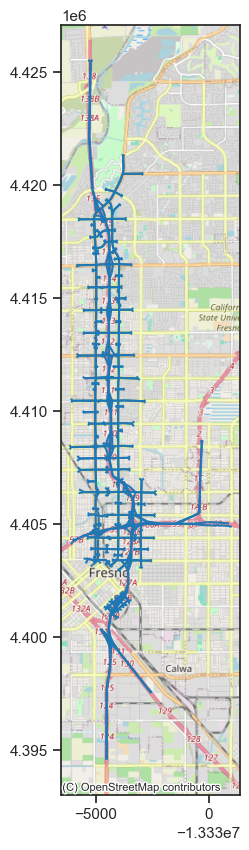

In [8]:
# Display network
fig, ax = plt.subplots(figsize=(10, 10))
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
links_gdf.to_crs(epsg=3857).plot(ax = ax)
ctx.add_basemap(ax = ax, source=ctx.providers.OpenStreetMap.Mapnik)

## Read and load OD matrix

In [9]:
read_OD(network=network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read and load paths

In [10]:
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-fresno-k3.csv')

#To generate K shortest paths and write in disk
# _K = 3
# load_k_shortest_paths(network=network, k=_K, theta = {'tt':-1}, update_incidence_matrices=True, block_output=False)
# write_paths(network.paths, filepath=f'input/network-data/fresno/paths/paths-fresno-k{_K}.csv')

20840 paths were read and incidence matrices were built


## Read and process spatio-temporal link-level data

In [11]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period'], format = '%Y-%m-%d-%H').dt.strftime('%Y-%m-%d-%H')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
# Select data from Tuesday (1) to Thursday (3)
df = df[df['date'].dt.dayofweek.isin(_DAYSOFWEEK)]
# Select data from one day only in 2019 and 2020
# df = df[df['date'].isin(["2019-10-01", "2020-10-06"])]

# # Select countdata from selected links
# selected_links = [(290,169,'0'),(170,168,'0'),(337,692,'0'),(228,192,'0'),(191,171,'0'),(188,87,'0'), (171,290,'0'),(192,191,'0'),(87,228,'0'),(169,332,'0'),(631,635,'0'),(179,183,'0'), (641,86,'0'),(638,634,'0'),(170,207,'0'),(86,189,'0'),(580,142,'0'),(333,332,'0'), (99,43,'0'),(637,639,'0')]
# df.loc[~df.link_key.isin(selected_links),'counts'] = float('nan')
# df.loc[~df.link_key.isin([(290,169,'0')]),'counts'] = float('nan')

In [12]:
df.head()

,link_key,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,pems_ids,link_type,id,...,median_inc,median_age,incidents,bus_stops,intersections,date,hour,tf_inrix,year,period
0,"(0, 1621, 0)",0,NaN,1800.0,0.098,45,1.626616e+09,[],LWRLK,1,...,93.828,31.1,0,0,1,2019-10-01,10,0.221,2019,2019-10-01-10
1,"(1239, 1630, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,565,...,0.000,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10
2,"(228, 192, 0)",1,1667.0,2400.0,0.110,65,1.626659e+09,[602350],LWRLK,564,...,37.414,16.6,0,0,0,2019-10-01,10,0.112,2019,2019-10-01-10
3,"(1243, 1631, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,563,...,0.000,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10
4,"(1244, 1632, 0)",0,NaN,inf,0.000,99999,NaN,[],DMDLK,562,...,0.000,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10


In [13]:
df.columns

Index(['link_key', 'observed', 'counts', 'capacity [veh]', 'tt_ff [min]',
       'speed_ff[mi/hr]', 'inrix_id', 'pems_ids', 'link_type', 'id', 'rhoj',
       'lane', 'ff_speed', 'length', 'alpha', 'beta', 'tf', 'k', 'inrix_id.1',
       'speed_avg', 'speed_ref_avg', 'speed_hist_avg', 'tt_avg', 'speed_max',
       'speed_sd', 'speed_cv', 'speed_hist_sd', 'speed_ref_sd', 'tt_sd',
       'tt_var', 'tt_cv', 'road_closures', 'median_inc', 'median_age',
       'incidents', 'bus_stops', 'intersections', 'date', 'hour', 'tf_inrix',
       'year', 'period'],
      dtype='object')

In [14]:
# Add period id for timevarying estimation
period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [15]:
# Curation of travel time and link flow related features
df = data_curation(df)

In [16]:
# Units of travel time features are converted from hours to minutes
df['tt_sd']= df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

In [17]:
# Set free flow travel times in links
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

# Set capacity in links considering number of lanes
capacity_links = df.groupby('link_key')['capacity'].mean()
for link in network.links:
    network.links_dict[link.key].performance_function.k = float(capacity_links[capacity_links.index==link.key].iloc[0])

## Process node-level data

In [18]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
# scaler = preprocessing.MinMaxScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Exploratory Data Analysis

In [19]:
df[['speed_ref_avg','speed_hist_avg','speed_max', 'tt_ff', 'tt_avg','tt_sd_adj']].describe()

,speed_ref_avg,speed_hist_avg,speed_max,tt_ff,tt_avg,tt_sd_adj
count,599370.000000,1.009583e+06,1.013460e+06,1.013460e+06,887813.000000,1.013460e+06
mean,32.540388,1.767589e+01,2.051278e+01,2.038423e-01,0.219493,3.022799e-04
std,15.223625,1.909664e+01,2.140424e+01,2.610045e-01,0.262030,4.638521e-04
min,8.078000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,24.233000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,26.719000,1.755400e+01,2.112700e+01,1.497376e-01,0.167050,1.856268e-04
75%,32.933000,2.547600e+01,3.106900e+01,2.792397e-01,0.312986,4.248116e-04
max,67.729000,7.891400e+01,8.388500e+01,4.220601e+00,3.827439,1.243267e-02


In [20]:
df.query('year == 2019')[['counts_lane', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts_lane,tt_ff,tt_avg,tf_inrix,tt_sd
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1488.711817,0.204903,0.221931,0.200169,0.018137
std,462.285984,0.262226,0.266852,0.228208,0.027831
min,0.779896,0.000000,0.000000,0.000000,0.000000
25%,1188.724832,0.000000,0.000000,0.000000,0.000000
50%,1494.280386,0.150455,0.168820,0.152000,0.011138
75%,1823.017903,0.282111,0.318261,0.280000,0.025489
max,2400.000000,4.220601,3.827439,2.302000,0.745960


In [21]:
df.query('year == 2020')[['counts_lane', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts_lane,tt_ff,tt_avg,tf_inrix,tt_sd
count,27472.000000,470535.000000,419510.000000,470535.000000,470535.000000
mean,1351.644684,0.202618,0.216770,0.198494,0.018137
std,450.202278,0.259583,0.256512,0.226003,0.027831
min,5.725646,0.000000,0.000000,0.000000,0.000000
25%,1038.280415,0.000000,0.000000,0.000000,0.000000
50%,1347.643221,0.149437,0.165341,0.150000,0.011138
75%,1681.922253,0.274658,0.306717,0.273000,0.025489
max,2400.000000,4.220601,3.274444,2.113000,0.745960


In [22]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts_lane']].mean().assign(total_obs = df.groupby('date')['hour'].count())

,speed_sd,speed_avg,counts_lane,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1497.588808,36195
2019-10-02,1.760109,17.169768,1476.571607,36195
2019-10-03,1.754288,17.092304,1509.584533,36195
2019-10-08,1.847060,18.165569,1478.300459,36195
2019-10-09,1.917923,18.137042,1481.272743,36195
2019-10-10,1.830232,18.107925,1514.981758,36195
2019-10-15,1.831527,18.114384,1480.838248,36195
2019-10-16,1.823680,18.162625,1486.702565,36195
2019-10-17,1.832219,18.080860,1501.029287,36195


In [23]:
## Link-level attributes in utility function
df[_FEATURES_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06
mean,1.813680e-02,2.621913e+01,7.441093e-01,1.500207e-01,8.765023e-01
std,2.783112e-02,2.135738e+01,3.193143e+00,4.411927e-01,1.319496e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.113761e-02,2.482100e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.548870e-02,4.168100e+01,0.000000e+00,0.000000e+00,1.000000e+00
max,7.459602e-01,1.158930e+02,4.000000e+01,4.000000e+00,9.000000e+00


## Training and validation sets

In [24]:
XT, YT = get_tensors_by_year(df[df.hour.isin(_HOURS)], features_Z = _FEATURES_Z, links_keys=list(network.links_dict.keys()))

XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

#Number of non-na observations of travel time and traffic flow
print('N', {k:tf.reduce_sum(tf.cast(tf.math.is_finite(v), tf.int32), axis = [0,1]).numpy() for k,v in YT.items()})
print('Coverage', {k:(tf.reduce_sum(tf.cast(tf.math.is_finite(v), tf.int32)/
                                   tf.reshape(YT[2019],(-1,YT[2019].shape[-1])).shape[0], axis = [0,1])).numpy() for k,v in YT.items()})

N {2019: array([468303,  31624], dtype=int32), 2020: array([419510,  27472], dtype=int32)}
Coverage {2019: array([0.8626, 0.0582]), 2020: array([0.7727, 0.0506])}


### Reference O-D matrix and trip generation vectors

In [25]:
q_historic = np.repeat(network.q.flatten()[np.newaxis, :], len(_HOURS), axis=0)

#Extrapolate reference O-D and historic trip generation available for 4pm to the rest of the hours by looking at link flow pattern over hours
generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

reference_q = q_historic*np.tile(generation_factors.values,(q_historic.shape[1],1)).T

reference_g = compute_generated_trips(q = reference_q, ods= network.ods, n_nodes = len(network.nodes))

## Models

In [26]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

### MaTE

In [27]:
print('\nMaTE: Macroscopic Traffic Estimation')

t0 = time.time()

models['MaTE'] = create_mate_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                                                      reference_g = reference_g, reference_q = reference_q, dtype = _DTYPE)

train_results_dfs['MaTE'], val_results_dfs['MaTE'] = models['MaTE'].fit(
    XT_train, YT_train, XT_val, YT_val,
    node_data=nodes_df,
    optimizers= _OPTIMIZERS['MaTE'],
    batch_size=_BATCH_SIZE,
    loss_weights= _LOSS_WEIGHTS['MaTE'],
    loss_metric=_LOSS_METRIC,
    evaluation_metric = _EVALUATION_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS['MaTE'])

print(f'runtime: {time.time()-t0:0.1f} [s]')

models['MaTE'].save_weights(f"output/models/{ts}_fresno_mate.h5")


MaTE: Macroscopic Traffic Estimation

Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 6 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 7 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 8 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 9 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 10 -> p-values k

In [28]:
metrics_df = models['MaTE'].compute_loss_metrics(
    metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
    X=XT_val, Y=YT_val).assign(dataset='validation')
metrics_df = pd.concat([metrics_df,
                        models['MaTE'].compute_loss_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
                            X=XT_train, Y=YT_train).assign(dataset='training'),
                        compute_benchmark_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
                            Y_ref=YT_train, Y=YT_val).assign(dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

metric                     mape  mdape      mse        r2
component   dataset                                      
equilibrium training   9.57e+13   4.58 1.47e+04     0.993
            validation 2.81e+16   5.13 3.77e+04     0.982
flow        benchmark       102     38 3.56e+06   -0.0352
            training       51.1   17.5 9.46e+05      0.77
            validation       39     22 1.28e+06     0.635
traveltime  benchmark      55.7   40.3   0.0658 -0.000404
            training       7.29   4.67  0.00281      0.96
            validation     10.7   6.85  0.00485     0.924


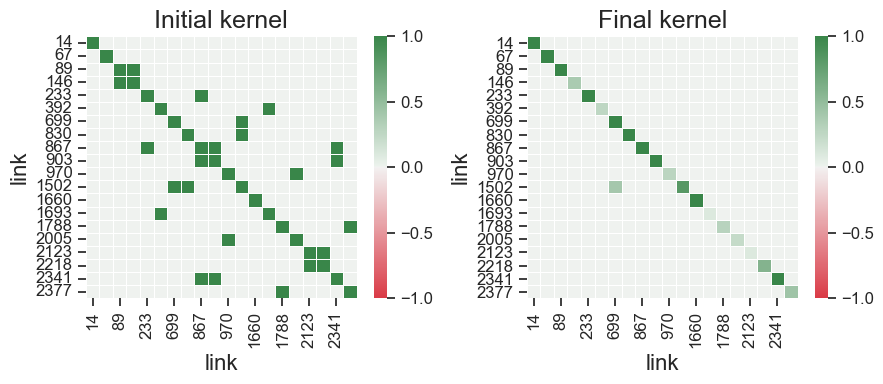

Final weights interaction:
 [[10.      0.      0.     ...  0.      0.      0.    ]
 [ 0.     10.      0.     ...  0.      0.      0.    ]
 [ 0.      0.4028  0.8328 ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...  2.0297  0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.2232  0.    ]
 [ 0.      0.      0.     ...  0.      0.      1.    ]]

Initial weights interaction:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [29]:
selected_links = np.random.choice(range(network.get_n_links()), 20, replace=False)

weights_interaction = models['MaTE'].performance_function.model.layers[0].kernel_matrix.numpy()
initial_weights_interaction = models['MaTE'].performance_function.kernel_constraint.initial_values.numpy()
# Plot sign of values in flow interaction matrix
plot_flow_interaction_matrix(
    flow_interaction_matrix=weights_interaction,
    masking_matrix = initial_weights_interaction,
    links_ids = selected_links + 1,
    vmin = -1, vmax = 1
)

plt.savefig('output/figures/results/fresno-kernel-link-performance-functions-mate.png', dpi = 300)

plt.show()

print(f'Final weights interaction:\n {weights_interaction}')
print(f'\nInitial weights interaction:\n',initial_weights_interaction)

# non_diagonal_mlp_weights = weights[~np.eye(weights.shape[0], dtype=bool)]
# print(f"Percentage of non-diagonal terms that are non-positive: {len(non_diagonal_mlp_weights[(non_diagonal_mlp_weights<=0)])/len(non_diagonal_mlp_weights):.2%}")

# non_zero_elements = weights_interaction[np.where(models['MaTE'].performance_function.kernel_constraint.initial_values.numpy()>0)]
# print(f"Percentage of non-zero terms that are positive: {len(non_zero_elements[(non_zero_elements>0)])/len(non_zero_elements):.2%}")

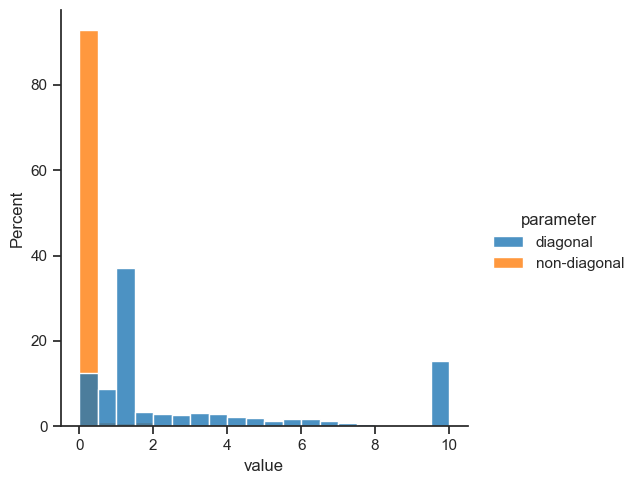

                 value  value_abs
parameter                        
diagonal      3.084871   3.084871
non-diagonal  0.239613   0.239613
              value
parameter          
diagonal       2413
non-diagonal  12314


In [30]:
# Distribution of weight in interaction flow matrix. Elements that are set to zero by default are excluded from non-diagonal
plot_data = pd.concat([pd.DataFrame({'value': tf.linalg.diag_part(weights_interaction).numpy().flatten(), 'parameter': 'diagonal'}),
                                  pd.DataFrame({'value': weights_interaction[np.where(~np.eye(weights_interaction.shape[0],dtype=bool)*models['MaTE'].performance_function.kernel_constraint.adjacency_constraint_matrix)], 'parameter': 'non-diagonal'})])

try:
    sns.displot(data = plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8,
                facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5) # , col="parameter"
    plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-mate.png', dpi = 300)
    plt.show()
except:
    print('Distribution plot could not be shown')

plot_data['value_abs'] = plot_data.value.abs()

print(plot_data.groupby('parameter')[['value', 'value_abs']].mean())
print(plot_data.groupby('parameter')[['value']].count())

In [31]:
# Weight of polynomial
print(f"polynomial weights {tf.reduce_mean(models['MaTE'].performance_function.polynomial_layer.poly_weights,0).numpy()}")

polynomial weights [0.1982 0.014  0.0124]


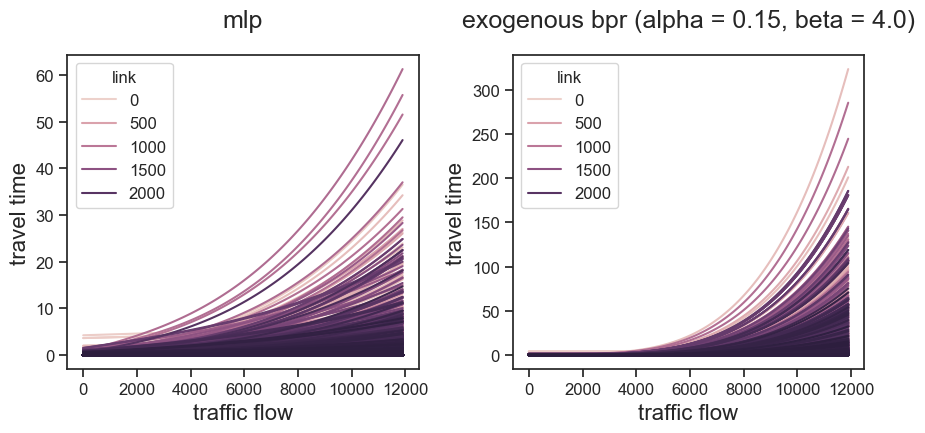

In [32]:
flow_range = range(0,12000,100)
sharey = False

plot_performance_functions(model = models['MaTE'],
                           network = network,
                           marginal = False,
                           alpha= 0.15,
                           beta= 4,
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-mate.png', dpi = 300)

plt.show()

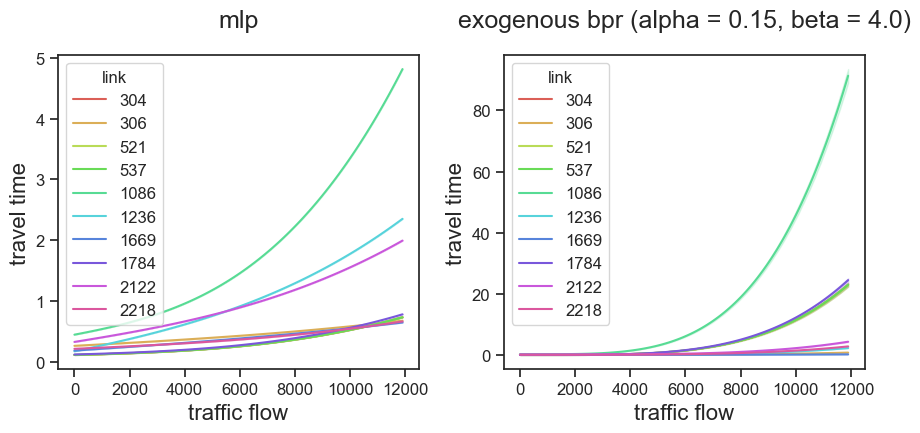

In [33]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model = models['MaTE'],
                           network = network,
                           marginal = True,
                           selected_links = selected_links,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.savefig('output/figures/results/fresno-comparison-some-link-performance-functions-mate.png', dpi = 300)

plt.show()

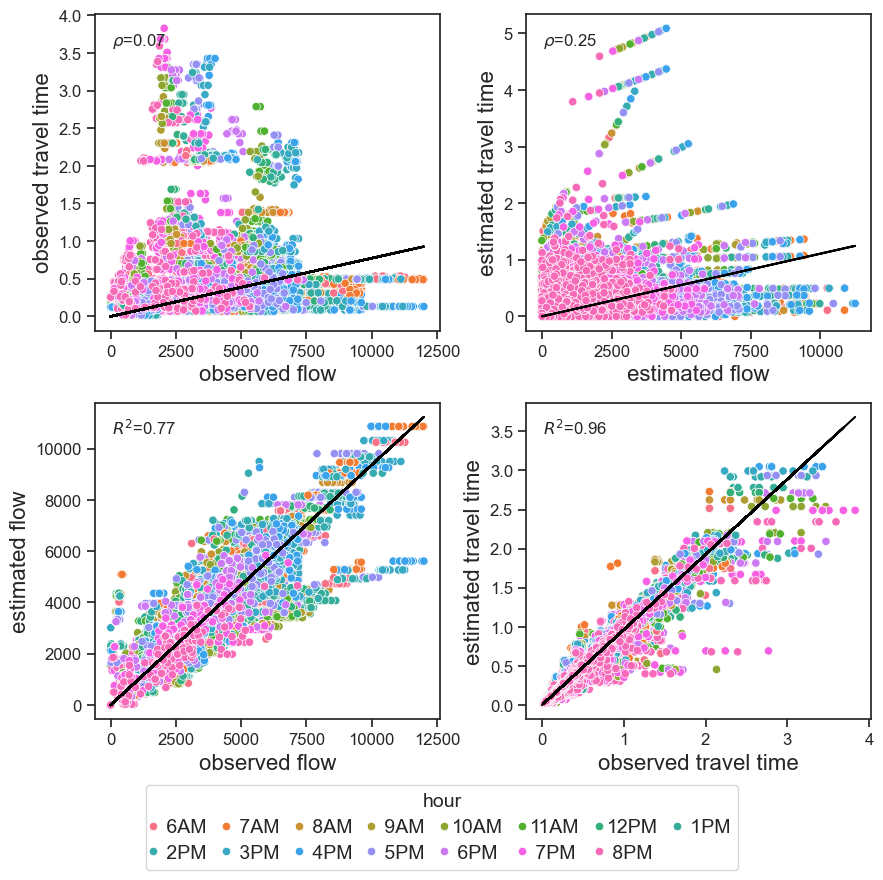

In [34]:
fig, axs = plot_flow_vs_traveltime(model = models['MaTE'],
                        observed_traveltime=models['MaTE'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['MaTE'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-mate.png', dpi = 300, bbox_inches='tight')

plt.show()

(<Figure size 550x500 with 1 Axes>, <Axes: xlabel='epoch', ylabel='mdape'>)

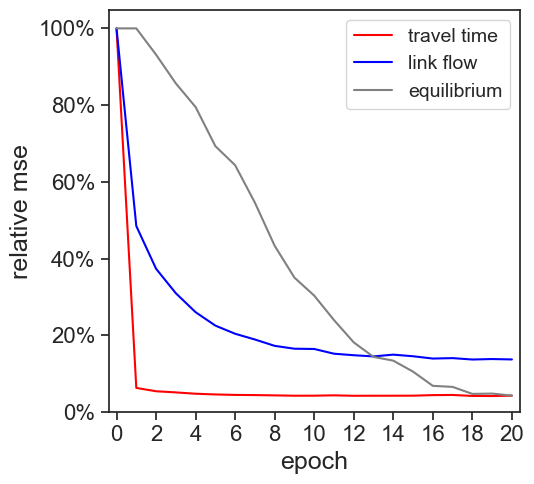

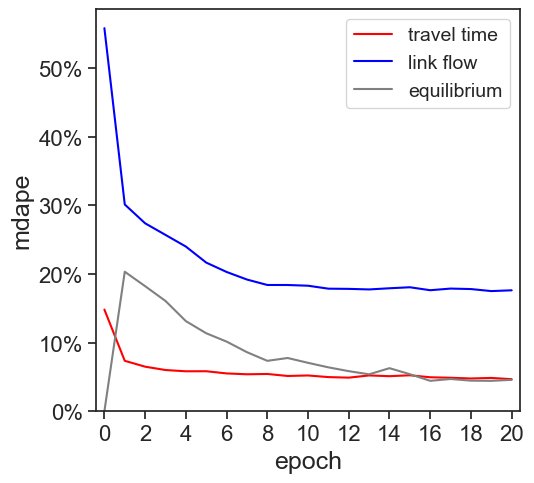

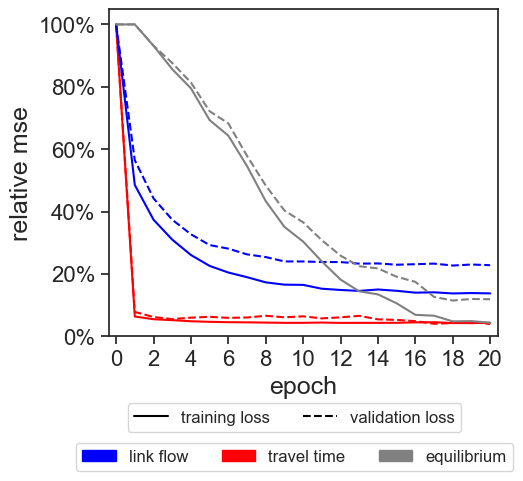

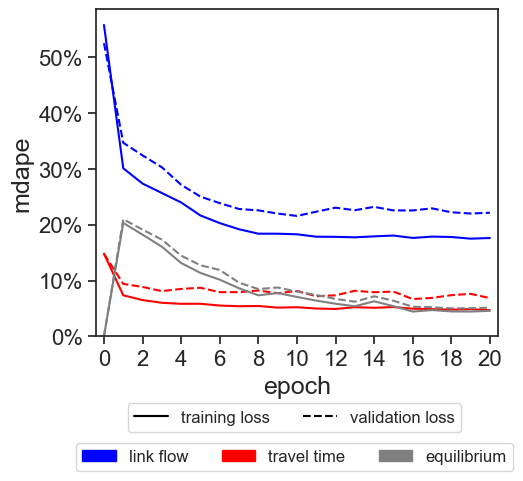

In [35]:
plot_predictive_performance(train_losses=train_results_dfs['MaTE'], val_losses=val_results_dfs['MaTE'],
                            curves=['travel time', 'link flow', 'equilibrium'],
                            xticks_spacing=2, show_validation=False)

plt.savefig(f'output/figures/results/fresno-relative-mse-mate.png', dpi=300)

plot_predictive_performance(train_losses=train_results_dfs['MaTE'], val_losses=val_results_dfs['MaTE'],
                            xticks_spacing=2, show_validation=False, show_percentage_units = True,
                            curves=['travel time', 'link flow', 'equilibrium'],
                            prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__}')

plt.savefig(f'output/figures/results/fresno-{_EVALUATION_METRIC.__name__}-mate.png', dpi = 300)

plot_predictive_performance(train_losses=train_results_dfs['MaTE'], val_losses=val_results_dfs['MaTE'],
                            curves=['travel time', 'link flow', 'equilibrium'],
                            xticks_spacing=2, show_validation=True)

plot_predictive_performance(train_losses=train_results_dfs['MaTE'], val_losses=val_results_dfs['MaTE'],
                            xticks_spacing=2, show_validation=True, show_percentage_units = True,
                            curves=['travel time', 'link flow', 'equilibrium'],
                            prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__}')

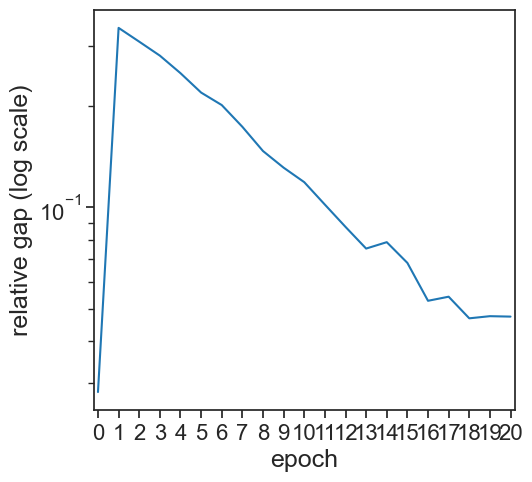

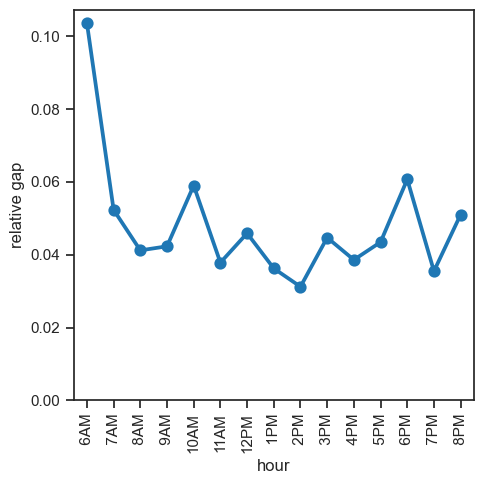

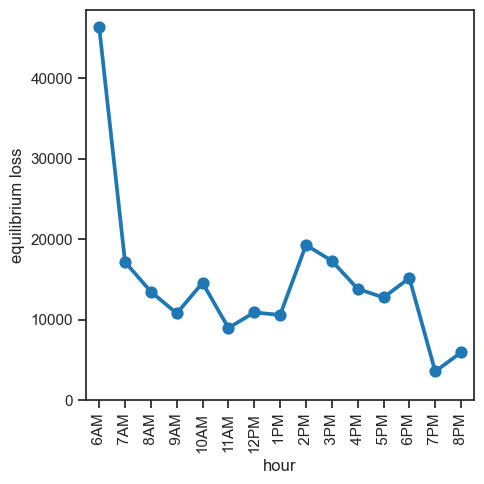

In [36]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['MaTE'].assign(
        relative_gap=np.abs(train_results_dfs['MaTE']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=1)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()
plt.savefig('output/figures/results/fresno-relative-gap-mate.png', dpi=300)
plt.show()

plot_relative_gap_by_period(model = models['MaTE'], period_keys = period_keys)
plt.savefig('output/figures/results/fresno-relative-gap-period-mate.png', dpi=300)
plt.show()

plot_equilibrium_loss_by_period(model = models['MaTE'], period_keys = period_keys)
plt.savefig('output/figures/results/fresno-equilibrium-loss-period-mate.png', dpi=300)
plt.show()

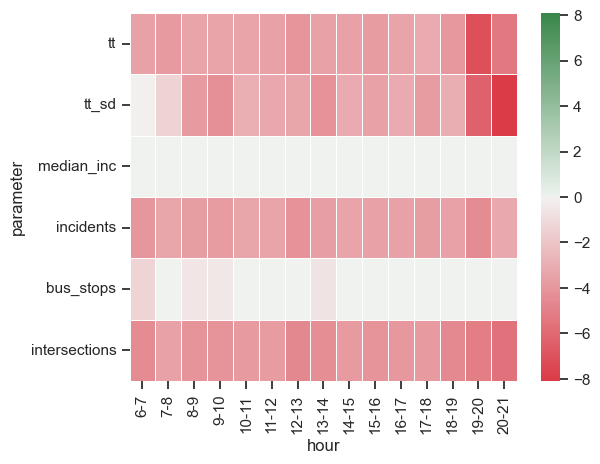

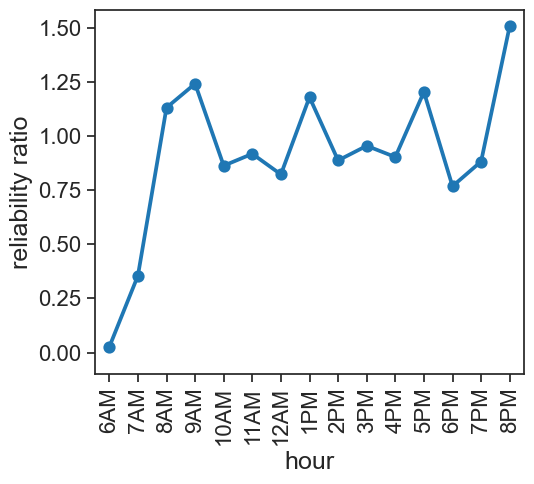

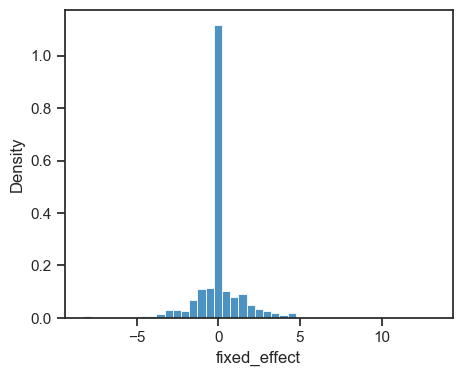

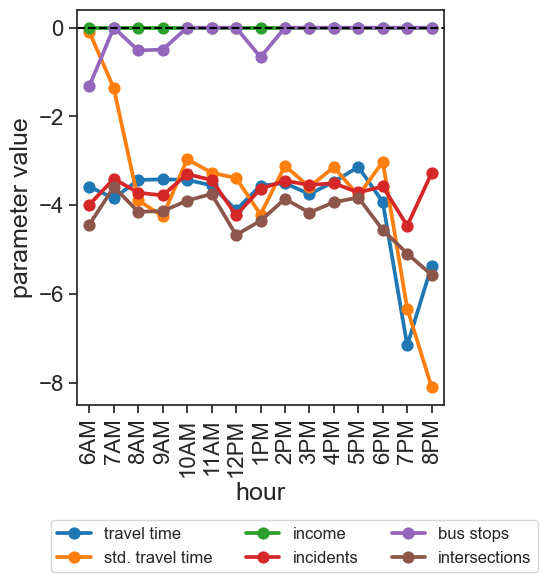

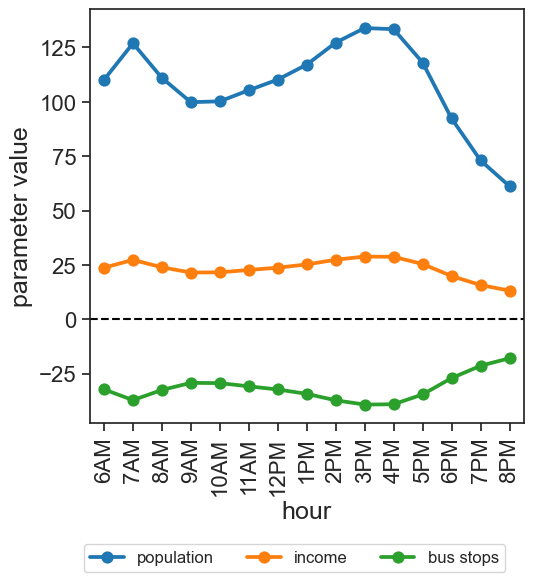

Theta: [[-3.5865 -3.8456 -3.4329 -3.4182 -3.4304 -3.555  -4.1111 -3.5637 -3.5046
  -3.7513 -3.4746 -3.1385 -3.9305 -7.1628 -5.3632]
 [-0.0925 -1.3664 -3.8896 -4.2518 -2.9654 -3.2686 -3.3882 -4.2109 -3.1149
  -3.588  -3.143  -3.7841 -3.0242 -6.3312 -8.1023]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.    ]
 [-3.9881 -3.4084 -3.7187 -3.7808 -3.302  -3.4322 -4.2262 -3.6329 -3.4492
  -3.5472 -3.5054 -3.7146 -3.5782 -4.4639 -3.276 ]
 [-1.3149  0.     -0.5146 -0.4935  0.      0.      0.     -0.6647  0.
   0.      0.      0.      0.      0.      0.    ]
 [-4.4391 -3.5906 -4.1488 -4.1355 -3.8984 -3.7465 -4.6713 -4.3526 -3.8599
  -4.167  -3.9346 -3.8281 -4.5596 -5.0909 -5.5737]]
Kappa: [[110.1214 126.9262 111.0016  99.823  100.2408 105.3369 110.2365 117.1173
  127.2416 133.9504 133.407  118.0597  92.3437  73.0533  61.1881]
 [ 23.6941  27.3098  23.8834  21.4782  21.5681  22.6646  23.7188  25.1993
   27.3777  28.8212  28.7043 

In [37]:
# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['MaTE'], period_keys = period_keys, period_feature='hour')
#print(theta_df.values)

plot_rr_by_period(models['MaTE'], period_keys, model_key = 'MaTE', period_feature='hour', rotation_xticks = 90)
plt.legend().remove()
plt.ylim(bottom=-0.1)
plt.savefig('output/figures/results/fresno-reliability-ratios-periods-mate.png', dpi = 300)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['MaTE'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

# Plot parameters by period
theta_df = plot_utility_parameters_periods(models['MaTE'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

# theta_df = pd.melt(theta_df.assign(rr = theta_df.apply(compute_rr, axis=1)), id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility')

kappa_df = pd.concat([pd.DataFrame({'period': [period], 'parameter': [feature], 'value': [models['MaTE'].kappa[period, i].numpy()]}) for period in range(models['MaTE'].kappa.shape[0]) for i, feature in enumerate(models['MaTE'].generation.features)]).assign(group = 'generation')

parameters_df = pd.concat([theta_df, kappa_df]).\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income', 'rr': 'reliability ratio'})

parameters_df['hour'] = parameters_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['MaTE'].period_dict.items()})

fig, ax = plot_parameters(df = parameters_df[parameters_df.group == 'utility'], n_cols_legend = 3, figsize = (5.5,6), hour_label = True, rotation_xticks = 90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-mate.png', dpi=300)

plot_parameters(df = parameters_df[parameters_df.group == 'generation'], n_cols_legend = 3, figsize = (5.5,6), hour_label = True, rotation_xticks = 90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-generation-periods-mate.png', dpi=300)

plt.show()

print('Theta:', models['MaTE'].theta.numpy().T)
print('Kappa:', models['MaTE'].kappa.numpy().T)

/Users/pablo/github/mate/src/mate/visualizations.py:771: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


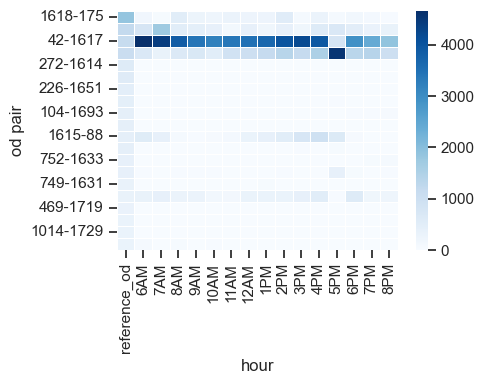

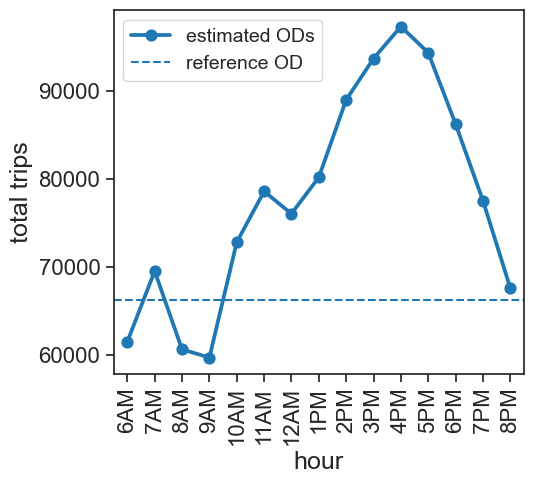

In [38]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['MaTE'],
                          reference_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20,
                          join_points = True, rotation_xticks = 90)

plt.savefig('output/figures/results/fresno-total-trips-periods-mate.png', dpi = 300)

In [39]:
print(f"theta = "
      f"{dict(zip(models['MaTE'].utility.true_values.keys(), list(np.mean(models['MaTE'].theta.numpy(), axis=0))))}")
print(f"kappa= "
      f"{dict(zip(models['MaTE'].generation.features, list(np.mean(models['MaTE'].kappa.numpy(), axis=0))))}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['MaTE'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -3.9512656, 'tt_sd': -3.6347358, 'median_inc': 0.0, 'incidents': -3.6682463, 'bus_stops': -0.19917385, 'intersections': -4.2664323}
kappa= {'population': 108.00316, 'income': 23.238293, 'bus_stops': -31.657713}
Avg abs diff of observed and estimated OD:  16.26
Avg observed OD:  9.51


### TVODLULPE

In [40]:
# To report runtime
t0 = time.time()

models['TVODLULPE'] = create_tvodlulpe_model_fresno(network = network, n_periods = n_periods,
                                                    reference_q = flat_od_from_generated_trips(reference_g, ods = network.ods),
                                                    # reference_q = reference_q,
                                                    features_Z = _FEATURES_Z, dtype = _DTYPE)

train_results_dfs['TVODLULPE'], val_results_dfs['TVODLULPE'] = models['TVODLULPE'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= _OPTIMIZERS['TVODLULPE'],
    node_data=nodes_df,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS['TVODLULPE'],
    loss_metric= _LOSS_METRIC,
    evaluation_metric = _EVALUATION_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS['TVODLULPE'])

print(f'runtime: {time.time()-t0:0.1f} [s]')

models['TVODLULPE'].save_weights(f"output/models/{ts}_fresno_tvodlulpe.h5")


Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      38  mdape
1  traveltime      40  mdape
0        flow 3.6e+06    mse
1  traveltime   0.066    mse
0        flow   1e+02   mape
1  traveltime      56   mape
0        flow  -0.035     r2
1  traveltime -0.0004     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 15, batch size: 1, threshold relative gap: inf
training set -> timepoints: 225, obs [t x]: [2081.  140.], coverage [t x]: [0.863 0.058]
validation set -> timepoints: 195, obs [t x]: [2151.  140.], coverage [t x]: [0.892 0.058]

Learning stage: 20 epochs

0/20: train mse=2e+06, train mse traveltime=0.073, train mdape traveltime=15.9 train mse flow=5.8e+06, train mdape flow=44.6, val mse=1.6e+06, val mse traveltime=0.1, val md

In [41]:
metrics_df = models['TVODLULPE'].compute_loss_metrics(
    metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
    X=XT_val, Y=YT_val).assign(dataset='validation')
metrics_df = pd.concat([metrics_df,
                        models['TVODLULPE'].compute_loss_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
                            X=XT_train, Y=YT_train).assign(dataset='training'),
                        compute_benchmark_metrics(
                            metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'mape': mape, 'r2': r2_score},
                            Y_ref=YT_train, Y=YT_val).assign(dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

metric                     mape  mdape      mse        r2
component   dataset                                      
equilibrium training   1.83e+12   3.47 1.52e+04     0.993
            validation 2.02e+16   4.19 4.28e+04      0.98
flow        benchmark       102     38 3.56e+06   -0.0352
            training       51.1   16.5 9.13e+05     0.778
            validation     37.5   21.2 1.15e+06     0.673
traveltime  benchmark      55.7   40.3   0.0658 -0.000404
            training       6.93   4.55  0.00241     0.966
            validation 1.86e+03   7.46 7.16e+04 -1.12e+06


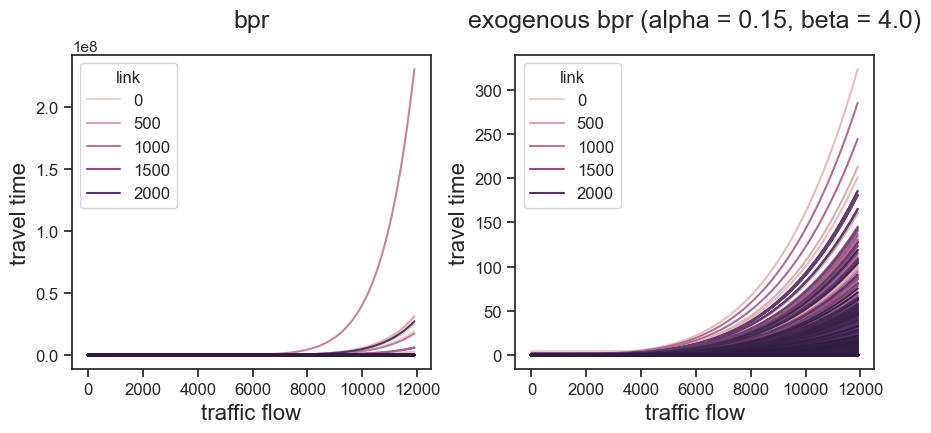

In [42]:
flow_range = range(0,12000,100)
sharey = False

fig, axs = plot_performance_functions(model = models['TVODLULPE'],
                                      network = network,
                                      marginal = False,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      )

plt.savefig('output/figures/results/fresno-comparison-all-link-performance-functions-tvodlulpe.png', dpi=300)

plt.show()

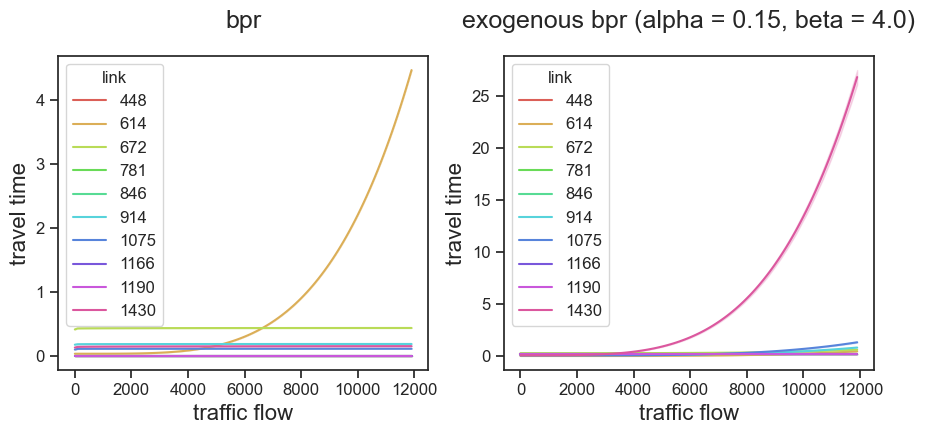

In [43]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model=models['TVODLULPE'],
                           network=network,
                           marginal=True,
                           # alpha=models['TVODLULPE'].performance_function.alpha,
                           # beta=models['TVODLULPE'].performance_function.beta,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

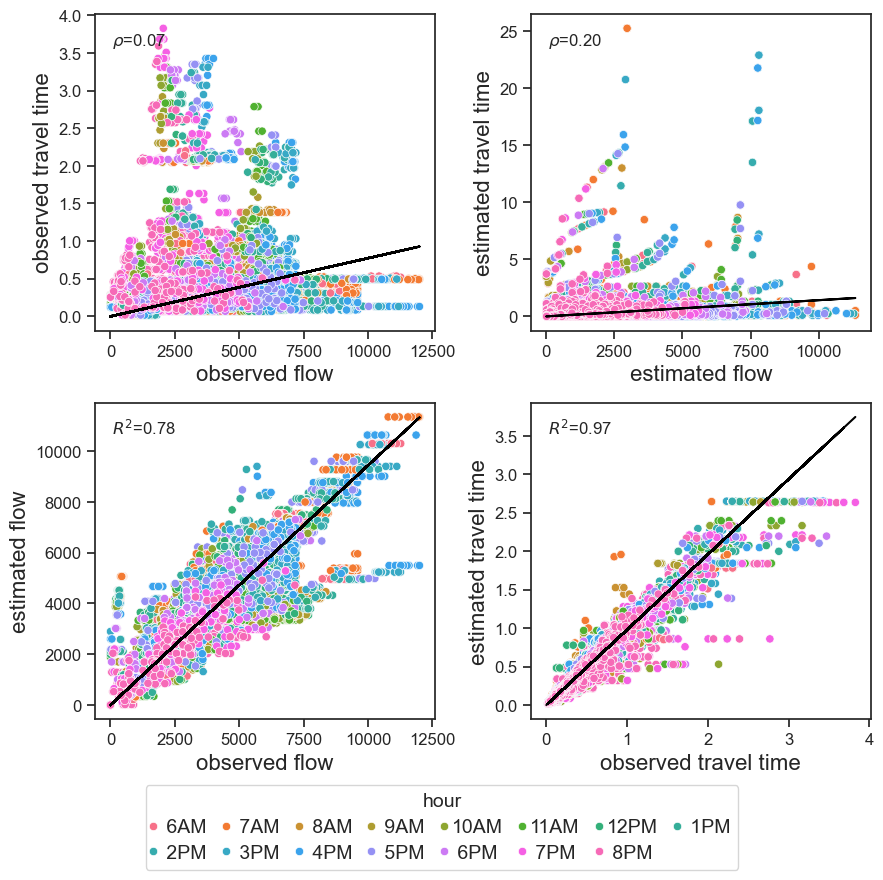

In [44]:
fig, axs = plot_flow_vs_traveltime(model = models['TVODLULPE'],
                        observed_traveltime=models['TVODLULPE'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['TVODLULPE'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )

plt.show()

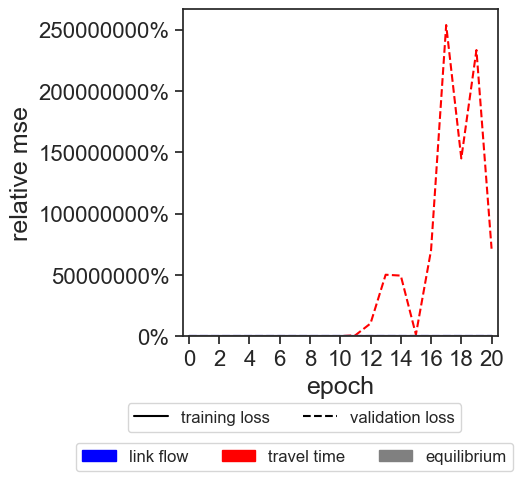

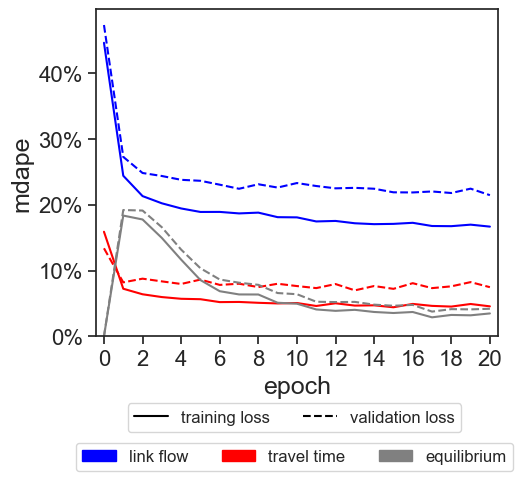

In [45]:
plot_predictive_performance(train_losses=train_results_dfs['TVODLULPE'], val_losses=val_results_dfs['TVODLULPE'],
                            curves=['travel time', 'link flow', 'equilibrium'],
                            xticks_spacing=2, show_validation=True)

plt.savefig(f'output/figures/results/fresno-relative-mse-tvodlulpe.png', dpi=300)

plot_predictive_performance(train_losses=train_results_dfs['TVODLULPE'], val_losses=val_results_dfs['TVODLULPE'],
                            xticks_spacing=2, show_validation=True, show_percentage_units = True,
                            curves=['travel time', 'link flow', 'equilibrium'],
                            prefix_metric=_EVALUATION_METRIC.__name__,
                            yaxis_label=f'{_EVALUATION_METRIC.__name__}')

plt.savefig(f'output/figures/results/fresno-{_EVALUATION_METRIC.__name__}-tvodlulpe.png', dpi=300)

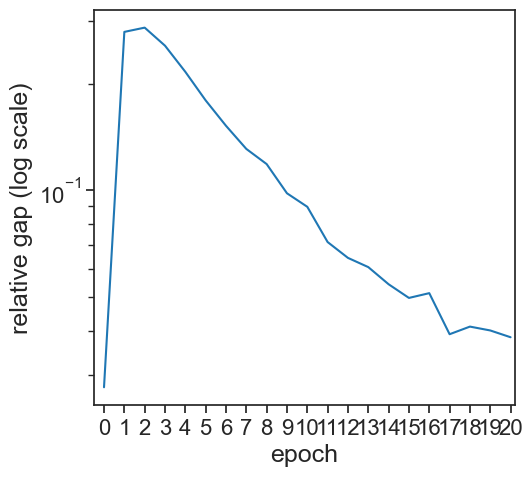

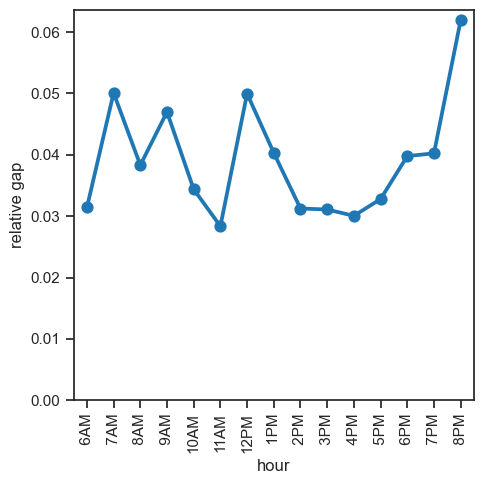

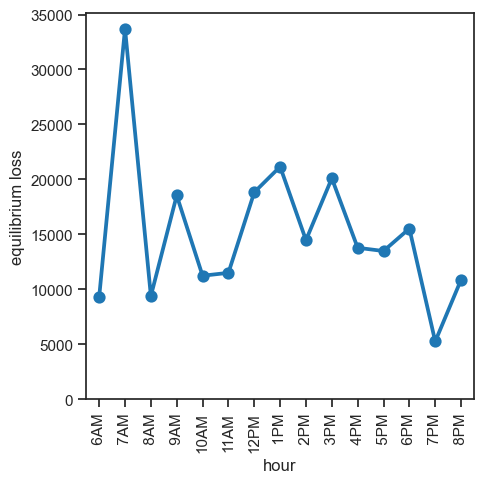

In [46]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['TVODLULPE'].assign(
        relative_gap=np.abs(train_results_dfs['TVODLULPE']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=1)

#ax.set_ylim(ymin=1e-2, ymax = 5.5e-2)
#ax.set_ylim(ymin=1e-2)
ax.set_xlim(xmin=-0.5)
ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()
plt.savefig('output/figures/results/fresno-relative-gap-tvodlulpe.png', dpi=300)

plot_relative_gap_by_period(model = models['TVODLULPE'], period_keys = period_keys)
plt.savefig('output/figures/results/fresno-relative-gap-period-tvodlulpe.png', dpi=300)

plot_equilibrium_loss_by_period(model = models['TVODLULPE'], period_keys = period_keys)
plt.savefig('output/figures/results/fresno-equilibrium-loss-period-tvodlulpe.png', dpi=300)

plt.show()

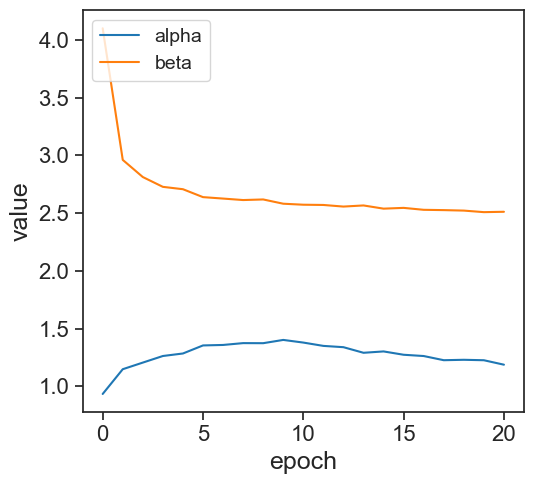

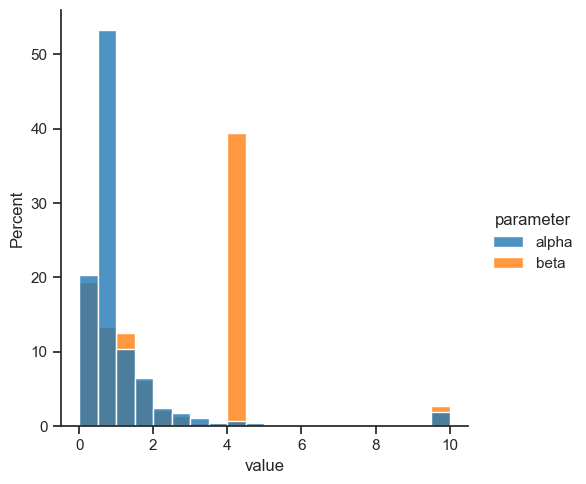

In [47]:
if models['TVODLULPE'].performance_function.type == 'bpr':

    plot_convergence_estimates(estimates=train_results_dfs['TVODLULPE'][['epoch', 'alpha', 'beta']],
                               xticks_spacing=5)
    plt.show()

    #sns.displot(plot_data, x="value", hue="parameter", multiple="stack", kind="hist", alpha=0.8, norm_hist=True)

    plot_data = pd.melt(pd.DataFrame({'alpha': models['TVODLULPE'].performance_function.alpha,
                                  'beta': models['TVODLULPE'].performance_function.beta}), var_name='parameter')

    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
    # sns.histplot(plot_data, x="value", stat='density', hue="parameter", alpha =0.8, ax = ax, binwidth = 0.5)

    try:
        sns.displot(plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.5)
        plt.savefig('output/figures/results/fresno-distribution-link-performance-parameters-tvodlulpe.png', dpi=300)
        plt.show()
    except:
        print('Distribution plot could not be shown')

             tt     tt_sd  median_inc  incidents  bus_stops  intersections  \
6-7   -2.972211 -3.381056         0.0  -3.857377        0.0      -4.023148   
7-8   -3.516409 -3.504481         0.0  -3.985035        0.0      -3.546880   
8-9   -4.266753 -4.224929         0.0  -3.401762        0.0      -3.998383   
9-10  -4.089688 -1.697436         0.0  -5.255395        0.0      -4.367619   
10-11 -4.463175 -2.526129         0.0  -4.092384        0.0      -3.187302   
11-12 -3.337288 -3.520046         0.0  -4.197052        0.0      -4.197663   
12-13 -4.070297 -4.996748         0.0  -2.871495        0.0      -5.822194   
13-14 -3.365663 -3.432358         0.0  -4.103338        0.0      -3.818905   
14-15 -4.477971 -3.158842         0.0  -3.683304        0.0      -3.650345   
15-16 -3.704663 -3.504494         0.0  -3.907399        0.0      -3.977898   
16-17 -4.002480 -3.082142         0.0  -4.943342        0.0      -3.693902   
17-18 -3.324486 -3.493353         0.0  -5.012150        0.0     

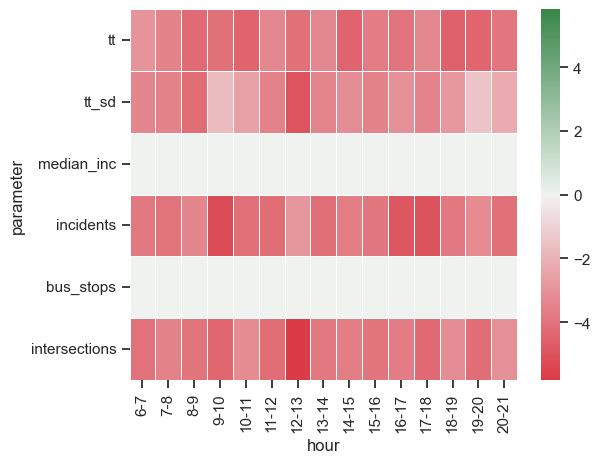

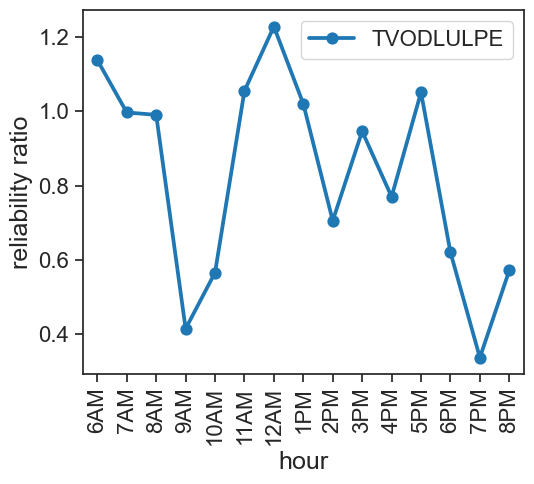

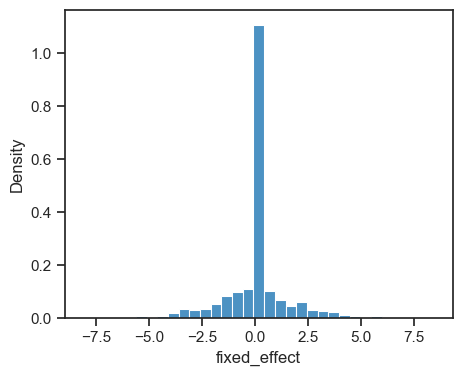

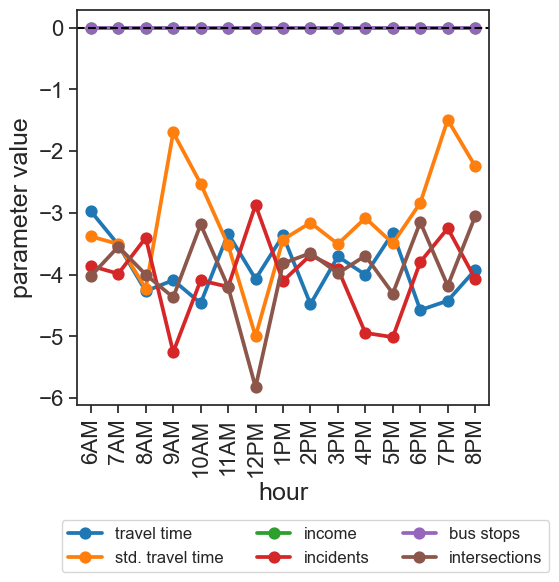

In [48]:
# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['TVODLULPE'], period_keys = period_keys, period_feature='hour')

print(theta_df)
#print(theta_df.values)

plot_rr_by_period(models['TVODLULPE'],period_keys, model_key = 'TVODLULPE', period_feature='hour', rotation_xticks = 90)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
sns.histplot(pd.DataFrame({'fixed_effect': np.array(models['TVODLULPE'].fixed_effect)}), stat='density', x="fixed_effect", alpha=0.8, ax = ax, binwidth=0.5)
plt.show()

theta_df = plot_utility_parameters_periods(models['TVODLULPE'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().\
    drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'rr': 'reliability ratio', 's': 'intersections', 'bus_stops': 'bus stops', 'median_inc': 'income'})

theta_df['hour'] = theta_df['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models['TVODLULPE'].period_dict.items()})

fig, axs = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (5.7,6), hour_label = True, rotation_xticks = 90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-utility-periods-tvodlulpe.png', dpi = 300)

plt.show()

/Users/pablo/github/mate/src/mate/visualizations.py:771: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


(           reference_od           6AM           7AM           8AM  \
 1618 175      1840.4001  2.692190e+02  2.797767e+02  2.150539e+02   
      694      1182.4533  3.479414e+02  3.932593e+02  2.681120e+02   
 42   1617     1139.6952  1.155428e+03  8.046749e+02  1.071282e+03   
 693  1617     1077.8859  1.692161e+03  1.277287e+03  1.391234e+03   
 272  1614      598.5315  1.548121e+00  4.742496e+01  2.682183e+01   
 701  1629      577.9746  1.315144e-03  8.563288e-05  1.013396e-03   
 226  1651      472.3362  7.547143e-04  2.894608e-04  4.253240e-02   
 220  1688      446.1534  6.765357e-02  2.005848e-01  7.074562e-02   
 104  1693      430.1766  1.997602e-01  3.353888e-03  6.854225e-04   
 871  1679      428.9796  1.903379e+01  1.402409e+01  2.178415e+00   
 1615 88        426.7179  5.866302e+02  4.118996e+02  2.141178e+02   
 807  1650      418.2822  1.016126e-10  3.371898e-05  1.278782e-09   
 752  1633      392.5845  5.942511e-16  1.347412e-22  4.897884e-21   
 42   88        386.

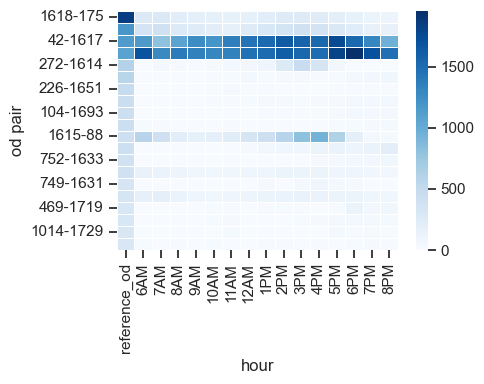

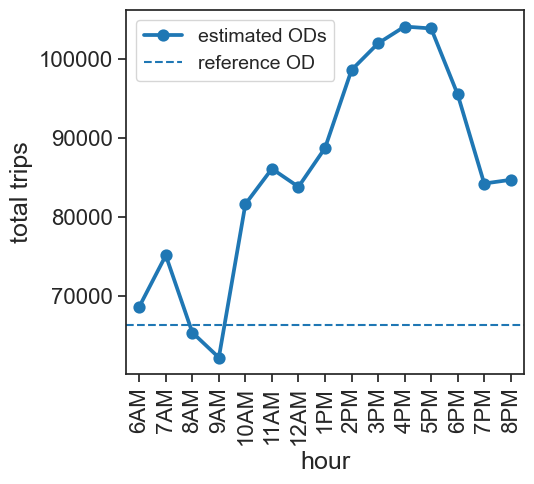

In [49]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['TVODLULPE'],
                          reference_od= network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20,
                          join_points = True,
                          rotation_xticks = 90)

In [50]:
print(f"theta = "
      f"{dict(zip(models['TVODLULPE'].utility.true_values.keys(), list(np.mean(models['TVODLULPE'].theta.numpy(), axis=0))))}")

if models['TVODLULPE'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['TVODLULPE'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['TVODLULPE'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['TVODLULPE'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -3.9007008, 'tt_sd': -3.139764, 'median_inc': 0.0, 'incidents': -4.0281296, 'bus_stops': 0.0, 'intersections': -3.9317625}
alpha =  1.19, beta  =  2.51
Avg abs diff of observed and estimated OD:  15.29
Avg observed OD:  9.51


## Write estimation results

In [51]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{ts}_train_results_{network.key}.csv"
val_filename = f"{ts}_validation_results_{network.key}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

File 240127164824_train_results_fresno.csv was written
File 240127164824_validation_results_fresno.csv was written


## Summary of parameter estimates

### All models

In [52]:
models

{'MaTE': <mate.models.mate at 0x3623bd3c0>,
 'TVODLULPE': <mate.models.mate at 0x290c3f610>}

In [53]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model_key, model in models.items():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model_key)

    results = pd.concat([results, model_results])

In [54]:
print(results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4))

model                 MaTE  TVODLULPE
parameter                            
tt                 -3.9513    -3.9007
tt_sd              -3.6347    -3.1398
median_inc          0.0000     0.0000
incidents          -3.6682    -4.0281
bus_stops          -0.1992     0.0000
intersections      -4.2664    -3.9318
rr                  0.9199     0.8049
fixed_effect_mean   0.0414     0.0229
fixed_effect_std    1.5411     1.5266
od_mean            11.1401    12.2882
od_std             72.1056    49.4144
alpha_mean             NaN     1.1864
alpha_std              NaN     1.4813
beta_mean              NaN     2.5116
beta_std               NaN     2.1218


### MaTE

In [55]:
# Stats by period
model = models['MaTE']

with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('theta:', pd.DataFrame(model.theta.numpy().T))

theta:        0       1       2       3       4       5       6       7       8   \
0 -3.5865 -3.8456 -3.4329 -3.4182 -3.4304 -3.5550 -4.1111 -3.5637 -3.5046   
1 -0.0925 -1.3664 -3.8896 -4.2518 -2.9654 -3.2686 -3.3882 -4.2109 -3.1149   
2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
3 -3.9881 -3.4084 -3.7187 -3.7808 -3.3020 -3.4322 -4.2262 -3.6329 -3.4492   
4 -1.3149  0.0000 -0.5146 -0.4935  0.0000  0.0000  0.0000 -0.6647  0.0000   
5 -4.4391 -3.5906 -4.1488 -4.1355 -3.8984 -3.7465 -4.6713 -4.3526 -3.8599   

       9       10      11      12      13      14  
0 -3.7513 -3.4746 -3.1385 -3.9305 -7.1628 -5.3632  
1 -3.5880 -3.1430 -3.7841 -3.0242 -6.3312 -8.1023  
2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
3 -3.5472 -3.5054 -3.7146 -3.5782 -4.4639 -3.2760  
4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
5 -4.1670 -3.9346 -3.8281 -4.5596 -5.0909 -5.5737  


In [56]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('kappa:', pd.DataFrame(model.kappa.numpy().T))

kappa:         0        1        2        3        4        5        6        7   \
0 110.1214 126.9262 111.0016  99.8230 100.2408 105.3369 110.2365 117.1173   
1  23.6941  27.3098  23.8834  21.4782  21.5681  22.6646  23.7188  25.1993   
2 -32.2786 -37.2044 -32.5366 -29.2600 -29.3824 -30.8762 -32.3123 -34.3292   

        8        9        10       11       12       13       14  
0 127.2416 133.9504 133.4070 118.0597  92.3437  73.0533  61.1881  
1  27.3777  28.8212  28.7043  25.4021  19.8690  15.7184  13.1654  
2 -37.2969 -39.2633 -39.1040 -34.6055 -27.0676 -21.4133 -17.9354  


In [57]:
# with pd.option_context('display.float_format', '{:0.1f}'.format):
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print('OD matrix', pd.DataFrame({'od_mean': np.mean(model.q,axis = 1), 'od_std': np.std(model.q, axis = 1), 'od_total':np.sum(model.q,axis = 1)}).T)

OD matrix                  0          1          2          3          4          5   \
od_mean      8.8299     9.9782     8.7059     8.5724    10.4474    11.2744   
od_std      78.5221    81.3923    70.1779    62.0591    61.8589    65.4038   
od_total 61544.5195 69548.3125 60680.0469 59749.4922 72818.5625 78582.8125   

                 6          7          8          9          10         11  \
od_mean     10.9113    11.5041    12.7632    13.4353    13.9547    13.5291   
od_std      65.5904    70.1467    78.0475    82.7981    80.8577    82.9298   
od_total 76051.6562 80183.4531 88959.8516 93643.7656 97264.5000 94297.5625   

                 12         13         14  
od_mean     12.3693    11.1241     9.7022  
od_std      70.8974    65.7855    57.7354  
od_total 86214.2656 77534.7188 67624.3594  


## Summary of models goodness of fit

In [58]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for model_key, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model_key])[1].assign(model=model_key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS[model_key]['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [59]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(results_losses[['model'] + list(results_losses.columns)])

        model  epoch  loss_traveltime               loss_od  loss_theta  \
20       MaTE     20         -95.6698                   NaN         NaN   
20  TVODLULPE     20         -96.7238 8002489944810060.0000         NaN   

    loss_flow  loss_equilibrium  loss_bpr  loss_ntrips          loss_prop_od  \
20   -86.2439          -95.6633       NaN          NaN                   NaN   
20   -84.2807          -94.4117       NaN          NaN 2057555004148819.0000   

    loss_regularizer_kernel  loss_regularizer_utility_ods  \
20                      NaN                           NaN   
20                      NaN                           NaN   

    loss_regularizer_od  loss_total  relative_gap      model  
20                  NaN    -86.1099        0.0473       MaTE  
20                  NaN    -84.1930        0.0384  TVODLULPE  


## Plot of convergence toward true rr across models

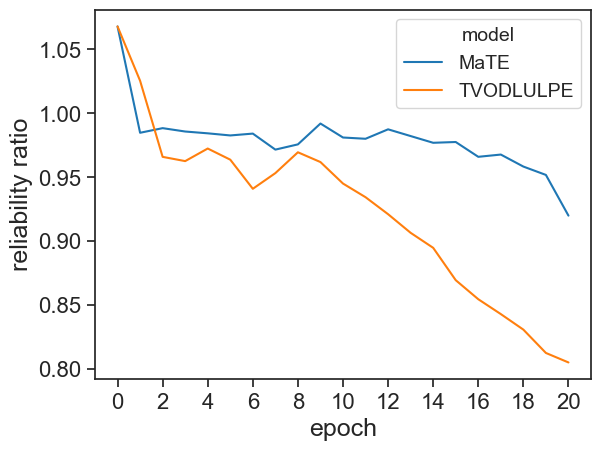

In [60]:
train_estimates = {}
train_losses = {}

for model_key, model in models.items():
    train_estimates[model_key], train_losses[model_key] = model.split_results(results=train_results_dfs[model_key])
    train_estimates[model_key]['model'] = model_key

train_estimates_df = pd.concat(train_estimates.values())
train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']
estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1)
g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel('reliability ratio', fontsize=18)
ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, 2))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, loc='upper right', title_fontsize=14, title = 'model')
plt.show()

## Plot of reliability ratio by hour for all models

/Users/pablo/github/mate/src/mate/visualizations.py:817: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=rr_by_hour_models, x=period_feature + '_id', y="rr", ax=ax,


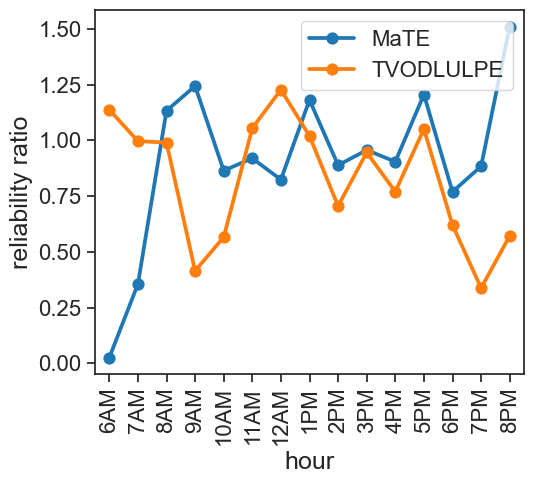

In [61]:
reliability_ratios = plot_rr_by_period_models(models, period_keys, period_feature='hour', join = True, rotation_xticks = 90)

plt.savefig('output/figures/results/fresno-reliability-ratios-periods.png', dpi = 300)

plt.show()

In [62]:
print(reliability_ratios)

          rr  hour hour_id      model
0   0.025789     6     6AM       MaTE
1   1.137556     6     6AM  TVODLULPE
2   0.355321     7     7AM       MaTE
3   0.996608     7     7AM  TVODLULPE
4   1.133039     8     8AM       MaTE
5   0.990198     8     8AM  TVODLULPE
6   1.243863     9     9AM       MaTE
7   0.415053     9     9AM  TVODLULPE
8   0.864447    10    10AM       MaTE
9   0.565994    10    10AM  TVODLULPE
10  0.919443    11    11AM       MaTE
11  1.054763    11    11AM  TVODLULPE
12  0.824151    12    12AM       MaTE
13  1.227613    12    12AM  TVODLULPE
14  1.181600    13     1PM       MaTE
15  1.019817    13     1PM  TVODLULPE
16  0.705418    14     2PM  TVODLULPE
17  0.888810    14     2PM       MaTE
18  0.956464    15     3PM       MaTE
19  0.945968    15     3PM  TVODLULPE
20  0.770058    16     4PM  TVODLULPE
21  0.904577    16     4PM       MaTE
22  1.050795    17     5PM  TVODLULPE
23  1.205684    17     5PM       MaTE
24  0.620733    18     6PM  TVODLULPE
25  0.769426

In [63]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    print(reliability_ratios[reliability_ratios.model == 'MaTE'][['hour','rr']].T)

         0      2      4      6       8       10      12      14      17  \
hour 6.0000 7.0000 8.0000 9.0000 10.0000 11.0000 12.0000 13.0000 14.0000   
rr   0.0258 0.3553 1.1330 1.2439  0.8644  0.9194  0.8242  1.1816  0.8888   

          18      21      23      25      27      28  
hour 15.0000 16.0000 17.0000 18.0000 19.0000 20.0000  
rr    0.9565  0.9046  1.2057  0.7694  0.8839  1.5107  


In [64]:
print(reliability_ratios.groupby('model')[['rr']].mean().round(4))

               rr
model            
MaTE       0.9111
TVODLULPE  0.8273


## Plot of total trips by hour for all models

/Users/pablo/github/mate/src/mate/visualizations.py:875: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  g = sns.pointplot(data=total_trips_by_hour_models, x=period_feature, y='total_trips', ax=ax,


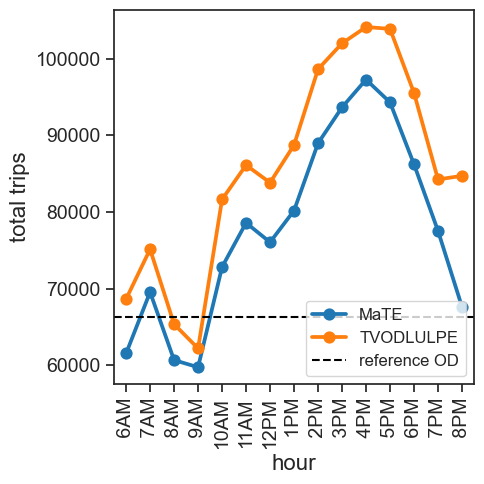

In [65]:
total_trips = plot_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys,
                                      reference_od = network.q.flatten(), join = True, rotation_xticks = 90)

plt.savefig('output/figures/results/fresno-total-trips-periods.png', dpi = 300)

plt.show()

In [66]:
print(total_trips)

    hour    total_trips      model  order
0    6AM   61544.535156       MaTE      6
0    6AM   68639.695312  TVODLULPE      6
1    7AM   69548.164062       MaTE      7
1    7AM   75138.984375  TVODLULPE      7
2    8AM   60680.121094       MaTE      8
2    8AM   65372.804688  TVODLULPE      8
3    9AM   59749.496094       MaTE      9
3    9AM   62199.003906  TVODLULPE      9
4   10AM   72818.648438       MaTE     10
4   10AM   81631.539062  TVODLULPE     10
5   11AM   78582.734375       MaTE     11
5   11AM   86111.156250  TVODLULPE     11
6   12PM   76051.890625       MaTE     12
6   12PM   83820.812500  TVODLULPE     12
7    1PM   80183.468750       MaTE     13
7    1PM   88731.648438  TVODLULPE     13
8    2PM   98616.195312  TVODLULPE     14
8    2PM   88959.953125       MaTE     14
9    3PM   93643.507812       MaTE     15
9    3PM  101990.796875  TVODLULPE     15
10   4PM  104119.554688  TVODLULPE     16
10   4PM   97264.523438       MaTE     16
11   5PM  103879.203125  TVODLULPE

In [67]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

,total_trips
model,
MaTE,77646.500000
TVODLULPE,85648.601562


In [68]:
total_trips.groupby('model')[['total_trips']].sum().round(1)

,total_trips
model,
MaTE,1164697.625
TVODLULPE,1284728.875


## Comparison of mate against historical mean

In [69]:
# Link-level spatial information
links_gdf['link_key'] = pd.Categorical(links_gdf['key'].apply(ast.literal_eval), list(network.links_dict.keys()))

# Create dataframe with data collected in 2020 during peak hours only
model_df = df[(df.hour.isin(_HOURS)) & (df['year']==2020)].sort_values(['period','link_key'])

_ = models['MaTE'].compute_loss_metrics(
    metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC}, X=XT_val, Y=YT_val)

# Build dataset witg data collected between 4-5pm in the first Tuesdays of Oct 2019 and 2020
benchmark_df = df[(df.hour == 16) & df['date'].isin(['2019-10-01', '2020-10-06'])].sort_values(['period','link_key'])

fig_speed, fig_flow = plot_congestion_maps(model=models['MaTE'], model_df=model_df, benchmark_df = benchmark_df,
                     gdf=links_gdf.sort_values(['link_key']), features=_FEATURES_Z, cmap = 'viridis',
                                           benchmark_model = 'historical_mean')

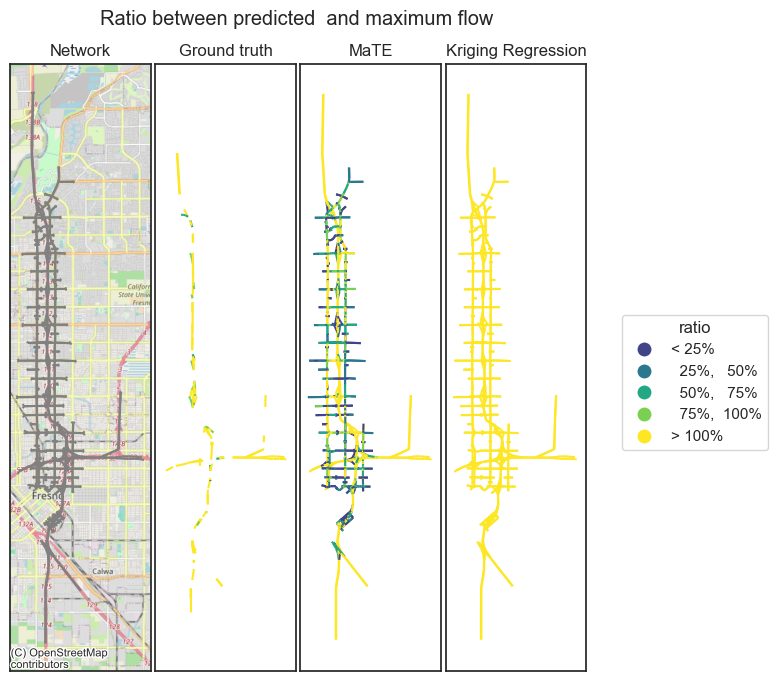

In [70]:
fig_flow

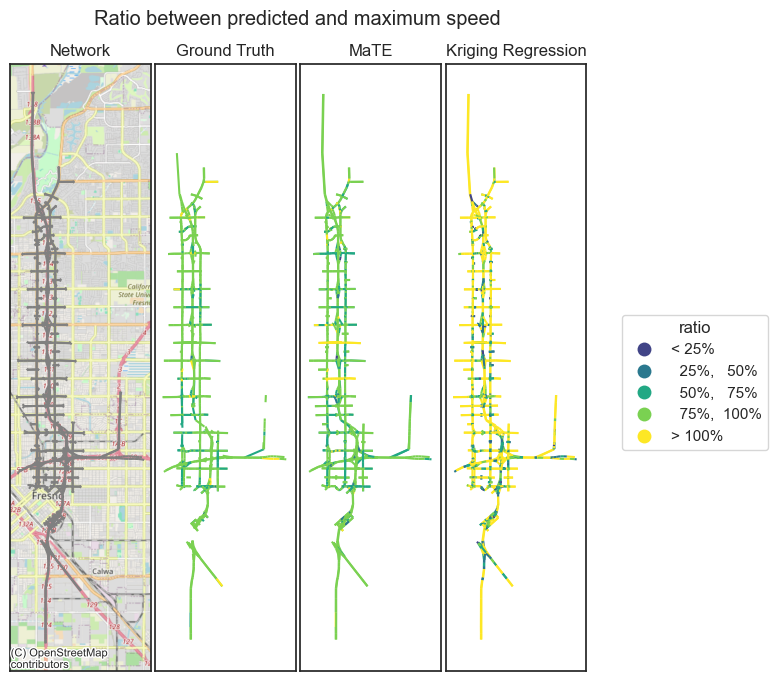

In [71]:
fig_speed



## Global runtime

In [72]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')

runtime: 21503.5 [s]
